In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib notebook

from sklearn.manifold import TSNE
from sklearn.svm import SVC, OneClassSVM
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score, cohen_kappa_score, f1_score

from sklearn.decomposition import NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from scipy.sparse import hstack
import datetime

import utils
import importlib
importlib.reload(utils)

double_figure = (7.2,7.2/8*5)
plt.rc('font',size=7)
plt.rc('axes',titlesize=7)
plt.rc('axes',labelsize=7)
plt.rc('xtick',labelsize=7)
plt.rc('ytick',labelsize=7)
plt.rc('legend',fontsize=7)
plt.rc('figure',titlesize=7)

In [2]:
df = pd.read_csv('docs.csv').sample(frac=1).reset_index(drop=True)
df['date'] = df['rated'].apply(lambda x: datetime.datetime.strptime(x[:19],"%Y-%m-%d %H:%M:%S"))
df = df[df['date'] > datetime.datetime(2018,6,1,0,0,0)].reset_index(drop=True)
print(df.shape)
y = df['relevant']
df.head()

(1984, 13)


,Unnamed: 0,UT_id,authors,content,first_author,id,rated,relevant,tag,title,wosarticle__de,wosarticle__wc,date
0,2170,WOS:000380832400013,"Crowe, SE, Bergquist, DC, Sanger, DM, Van Dola...",Dredging of nearshore subtidal sand deposits a...,"Crowe, SE",686936,2018-09-21 08:11:28.726712+00:00,1,760,Physical and Biological Alterations Following ...,Renourishment; disturbance; benthic community;...,"['Environmental Sciences; Geography, Physical;...",2018-09-21 08:11:28
1,2102,WOS:000302524600037,"Lee, KY, Kumar, B, Seo, JS, Kim, KH, Sohn, JI,...",Enhancing the output power of a nanogenerator ...,"Lee, KY",675682,2018-09-19 19:30:55.473766+00:00,0,753,P-Type Polymer-Hybridized High-Performance Pie...,Piezoelectricity; nanogenerator; zinc oxide; p...,"['Chemistry, Multidisciplinary; Chemistry, Phy...",2018-09-19 19:30:55
2,1750,WOS:000335424100024,"Haller, A",Policy makers concerned with the pen-urban int...,"Haller, A",497700,2018-09-07 08:03:22.113585+00:00,1,737,"The ""sowing of concrete"": Peri-urban smallhold...",Environmental perception; Pen-urban growth; La...,['Environmental Studies'],2018-09-07 08:03:22
3,1775,WOS:000269375900006,"Baudron, F, Corbeels, M, Monicat, F, Giller, KE",We review agricultural impacts on biodiversity...,"Baudron, F",625142,2018-09-21 09:06:55.378895+00:00,1,760,Cotton expansion and biodiversity loss in Afri...,Cotton; Smallholders; Productivity; Sustainabi...,['Biodiversity Conservation; Ecology; Environm...,2018-09-21 09:06:55
4,2440,WOS:000370993200057,"Verge, X, Maxime, D, Desjardins, RL, VanderZaa...",The choice of the calculation pathways used to...,"Verge, X",684705,2018-09-21 04:12:15.248619+00:00,1,753,Allocation factors and issues in agricultural ...,Allocation; Life cycle analysis; Greenhouse ga...,['GREEN & SUSTAINABLE SCIENCE & TECHNOLOGY; En...,2018-09-21 04:12:15


### The sample is unbalanced, with 22% negatives

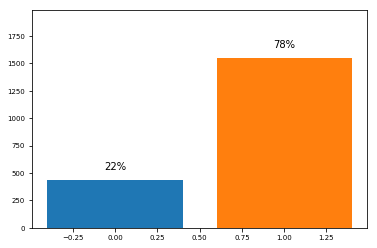

In [3]:
plt.close()
fig, ax = plt.subplots()
i = 0
for name, group in df.groupby('relevant'):
    s = group['id'].size
    plt.bar(i, s)
    plt.text(i, s + df['id'].size*0.05, "{:.0%}".format(s/df['id'].size),ha="center")
    i+=1
    
plt.ylim(0,df['id'].size)
#fig.tight_layout()
    
plt.show()
    

## Generating various feature collections for input

In [4]:
vec = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=15, max_df=0.6, strip_accents='unicode', 
    use_idf=1,
    smooth_idf=1, sublinear_tf=1,
    stop_words="english",tokenizer=utils.tokenize
)

ab_X = vec.fit_transform(df['content'])
ab_X.shape

(1984, 2088)

In [5]:
vec = TfidfVectorizer(
    ngram_range=(1,3),
    min_df=5, max_df=0.8, strip_accents='unicode', 
    use_idf=1,
    smooth_idf=1, sublinear_tf=1,
    stop_words="english",tokenizer=utils.tokenize
)

ab_X_dense = vec.fit_transform(df['content'])
ab_X_dense.shape

(1984, 6368)

In [6]:
vec = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=10, max_df=0.9, strip_accents='unicode', 
    use_idf=1,
    smooth_idf=1, sublinear_tf=1,
    stop_words="english",tokenizer=utils.tokenize
)


ti_X = vec.fit_transform(df['title'])
ti_X.shape

(1984, 358)

In [7]:
# keywords
import re
def kw_tokenize(X):
    for x in X.split(';'):
        t = x.replace('[','').replace(']','').strip()
        t = t.replace("'","")
        t = re.sub('^, ','',t)
        t = t.replace(',,',',')
        if len(x) < 2:
            continue
        yield t

vec = CountVectorizer(
    min_df=3, max_df=0.9, strip_accents='unicode', 
    stop_words="english",
    tokenizer=kw_tokenize
)
df['wosarticle__wc'] = df['wosarticle__wc'].fillna("")
wc_X = vec.fit_transform(df['wosarticle__wc'])
print(wc_X.shape)
vec.get_feature_names()[:5]

(1984, 162)


['agricultural economics & policy',
 'agricultural engineering',
 'agriculture, dairy & animal science',
 'agriculture, multidisciplinary',
 'agronomy']

In [8]:
# keywords

vec = CountVectorizer(
    min_df=3, max_df=0.9, strip_accents='unicode', 
    stop_words="english",
    tokenizer=kw_tokenize
    #tokenizer=lambda x: x.split('; ')
)
df['wosarticle__de'] = df['wosarticle__de'].fillna("")
de_X = vec.fit_transform(df['wosarticle__de'])
print(de_X.shape)
vec.get_feature_names()[:5]

(1984, 323)


['activated carbon',
 'adaptation',
 'adsorption',
 'africa',
 'agricultural sustainability']

In [9]:
vec = CountVectorizer(
    ngram_range=(1,1),
    min_df=1, max_df=0.9, strip_accents='unicode', 
    stop_words="english",tokenizer=utils.tokenize
)
df['authors'] = df['authors'].fillna("")
au_X = vec.fit_transform(df['authors'])
print(au_X.shape)
vec.get_feature_names()[:5]

vec = CountVectorizer(
    min_df=3, max_df=0.9, strip_accents='unicode', 
    stop_words="english",
    tokenizer=utils.sus_tokenize
    #tokenizer=lambda x: x.split('; ')
)
sus_X = vec.fit_transform(df['content'])
print(sus_X.shape)
vec.get_feature_names()[:25]

(1984, 5561)
(1984, 405)


['2005_1',
 '2015_1',
 'acceptable_-1',
 'achieve_-1',
 'achieving_-1',
 'activity_-1',
 'activity_1',
 'advance_-1',
 'agricultural_-1',
 'agricultural_1',
 'agriculture._1',
 'agriculture_1',
 'along_-1',
 'also_1',
 'alternative_-1',
 'alternative_1',
 'alternatives_1',
 'application_-1',
 'approach_-1',
 'approach_1',
 'approaches_-1',
 'approaches_1',
 'aquaculture._1',
 'aquaculture_1',
 'areas._-1']

In [10]:
vec = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=10, max_df=0.9, strip_accents='unicode', 
    use_idf=1,
    smooth_idf=1, sublinear_tf=1,
    stop_words="english",tokenizer=utils.tokenize
)


ti_X = vec.fit_transform(df['title'])
ti_X.shape

(1984, 358)

In [11]:
X = X = hstack([ab_X,ti_X,wc_X,de_X],format="csr")
X.shape

(1984, 2931)

In [12]:
nmf = NMF(n_components=125,random_state=1,
          alpha=.1, l1_ratio=.5)

W = nmf.fit_transform(X)

## Testing the different feature collections with various models

In [31]:
#ab, ti, de, au, wc, W

xs = [
    {
        'title':'abstracts',
        'X': ab_X
    },
    {
        'title':'keywords',
        'X': de_X
    },
#]
#extra_xs = [
    {
        'title':'titles, abs,\nkw, wc',
        'X': hstack([ab_X,ti_X,de_X,wc_X],format="csr")
    },
    {
        'title':'titles, abs',
        'X': hstack([ab_X,ti_X],format="csr")
    },
    {
        'title':'topic_model_all',
        'X': W
    },
    {
        'title': 'abs, kw, sus',
        'X': hstack([ab_X,de_X,sus_X],format="csr")
    }
]
import copy
models = [
    {
        'title': 'SVM', 
        'model': SVC(kernel='linear',C=5,probability=True)
    },
    {
        'title':"Neural Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )
    },
    {
        'title': 'Naive Bayes', 
        'model': MultinomialNB(alpha=0.1)     
    }
]
for model in models:
    model['p'] = []
    model['r'] = []
    model['e'] = []
    model['i'] = []
    model['f'] = []

kf = KFold(n_splits=10)

for x in xs:
    print(x['title'])
    x['models'] = copy.deepcopy(models)
    local_x = x['X']
    i=0
    for train_index, test_index in kf.split(X):
        #train_index = utils.undersample(train_index,y,0.4)
        for j,model in enumerate(x['models']):
            clf = model['model']
            i+=1
            model['i'].append(i)
            #clf = SVC(kernel='rbf',probability=True)
            clf.fit(local_x[train_index],y[train_index])
            predictions = clf.predict(local_x[test_index])
            x['models'][j]['e'].append(clf.score(local_x[test_index],y[test_index]))
            # Precision
            x['models'][j]['p'].append(precision_score(predictions,y[test_index]))
            # Recall
            x['models'][j]['r'].append(recall_score(predictions,y[test_index]))
            x['models'][j]['f'].append(f1_score(predictions,y[test_index]))
        

abstracts
keywords
titles, abs,
kw, wc
titles, abs
topic_model_all
abs, kw, sus


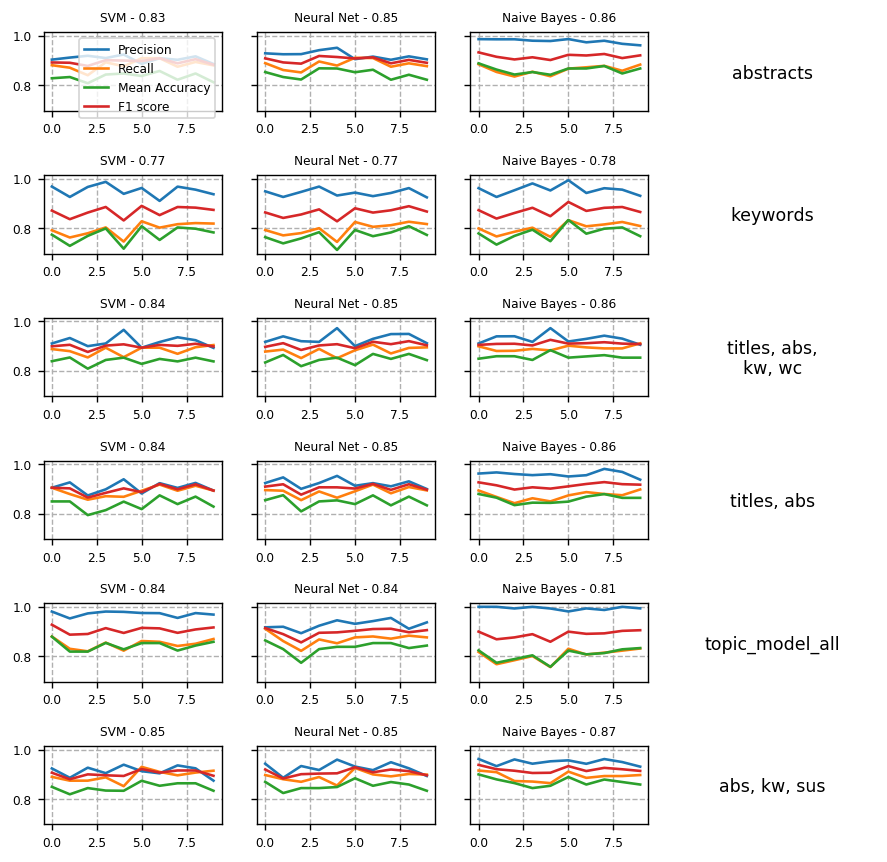

In [32]:
plt.rcParams['grid.linestyle'] = "--"
fig, axs = plt.subplots(
    len(xs),
    len(xs[0]['models'])+1,
    dpi=125,
    figsize=(double_figure[0],7),
    sharey=True
)
for i, x in enumerate(xs):
    for j, model in enumerate(x['models']):
        ax = axs[i,j]
        ax.plot(model['p'],label="Precision")
        ax.plot(model['r'],label="Recall")
        ax.plot(model['e'],label="Mean Accuracy")
        ax.plot(model['f'],label="F1 score")

        ax.set_title("{} - {:.2f}".format(model['title'],np.mean(model['e'])))
        ax.grid()
    ax = axs[i,3]
    ax.text(0.5,0.85,x['title'],ha="center",va="center")
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
    ax.axis('off')
axs[0,0].legend()
fig.tight_layout()
#plt.savefig("plots/model_comparison.png")


In [33]:
#ab, ti, de, au, wc, W

xs = [
    {
        'title':'abstracts',
        'X': ab_X
    },
    {
        'title':'keywords',
        'X': de_X
    },
#]
#extra_xs = [
    {
        'title':'titles, abs,\nkw, wc',
        'X': hstack([ab_X,ti_X,de_X,wc_X],format="csr")
    },
    {
        'title':'titles, abs',
        'X': hstack([ab_X,ti_X],format="csr")
    },
    {
        'title':'topic_model_all',
        'X': W
    },
    {
        'title': 'abs, kw, sus',
        'X': hstack([ab_X,de_X,sus_X],format="csr")
    }
]
import copy
models = [
    {
        'title': 'SVM', 
        'model': SVC(kernel='linear',C=5,probability=True)
    },
    {
        'title':"Neural Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )
    },
    {
        'title': 'Naive Bayes', 
        'model': MultinomialNB(alpha=0.1)     
    }
]
for model in models:
    model['p'] = []
    model['r'] = []
    model['e'] = []
    model['i'] = []
    model['f'] = []


for x in xs:
    x['models'] = copy.deepcopy(models)
    local_x = x['X']
    i=0
    print(x['title'])
    for s in range(9):
        train = df.sample(frac=(s+1)*0.1).copy()
        test = df[~df['id'].isin(train['id'])].copy()
        train_index = train.index
        test_index = test.index
        #train_index = utils.undersample(train_index,y,0.4)
        for j,model in enumerate(x['models']):
            clf = model['model']
            i+=1
            model['i'].append(i)
            #clf = SVC(kernel='rbf',probability=True)
            clf.fit(local_x[train_index],y[train_index])
            predictions = clf.predict(local_x[test_index])
            x['models'][j]['e'].append(clf.score(local_x[test_index],y[test_index]))
            # Precision
            x['models'][j]['p'].append(precision_score(predictions,y[test_index]))
            # Recall
            x['models'][j]['r'].append(recall_score(predictions,y[test_index]))
            x['models'][j]['f'].append(f1_score(predictions,y[test_index]))
        

abstracts
keywords
titles, abs,
kw, wc
titles, abs
topic_model_all
abs, kw, sus


In [16]:
## Most models work fairly well even with small training sets

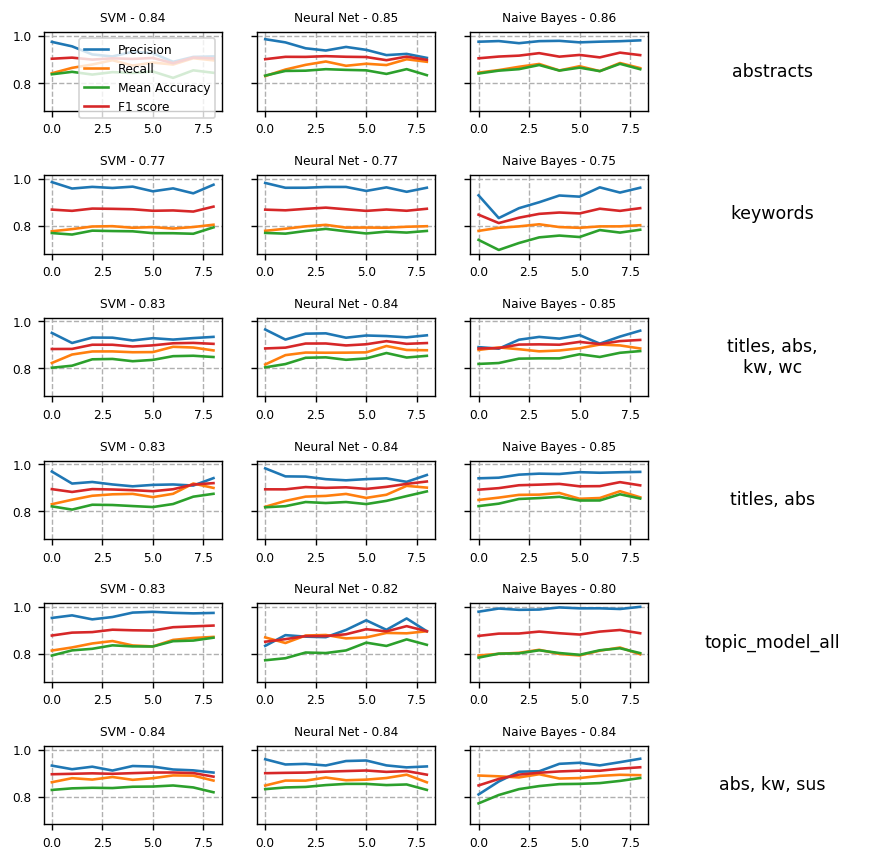

In [34]:
plt.rcParams['grid.linestyle'] = "--"
fig, axs = plt.subplots(
    len(xs),
    len(xs[0]['models'])+1,
    dpi=125,
    figsize=(double_figure[0],7),
    sharey=True
)
for i, x in enumerate(xs):
    for j, model in enumerate(x['models']):
        ax = axs[i,j]
        ax.plot(model['p'],label="Precision")
        ax.plot(model['r'],label="Recall")
        ax.plot(model['e'],label="Mean Accuracy")
        ax.plot(model['f'],label="F1 score")

        ax.set_title("{} - {:.2f}".format(model['title'],np.mean(model['e'])))
        ax.grid()
    ax = axs[i,3]
    ax.text(0.5,0.85,x['title'],ha="center",va="center")
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
    ax.axis('off')
axs[0,0].legend()
fig.tight_layout()
#plt.savefig("plots/model_comparison.png")


## Undersampling

In [35]:
#ab, ti, de, au, wc, W

xs = [
    {
        'title':'abstracts',
        'X': ab_X
    },
    {
        'title':'keywords',
        'X': de_X
    },
#]
#extra_xs = [
    {
        'title':'titles, abs,\nkw, wc',
        'X': hstack([ab_X,ti_X,de_X,wc_X],format="csr")
    },
    {
        'title':'titles, abs',
        'X': hstack([ab_X,ti_X],format="csr")
    },
    {
        'title':'topic_model_all',
        'X': W
    },
    {
        'title': 'abs, kw, sus',
        'X': hstack([ab_X,de_X,sus_X],format="csr")
    }
]
import copy
models = [
    {
        'title': 'SVM', 
        'model': SVC(kernel='linear',C=5,probability=True)
    },
    {
        'title':"Neural Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )
    },
    {
        'title':"Big Neural Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(100,10,5), 
            random_state=1
        )
    },
    {
        'title': 'Naive Bayes', 
        'model': MultinomialNB(alpha=0.1)     
    }
]
for model in models:
    model['p'] = []
    model['r'] = []
    model['e'] = []
    model['i'] = []
    model['f'] = []


for x in xs:
    x['models'] = copy.deepcopy(models)
    local_x = x['X']
    i=0
    print(x['title'])
    for s in range(9):
        train = df.sample(frac=(s+1)*0.1).copy()
        test = df[~df['id'].isin(train['id'])].copy()
        train_index = utils.undersample(train.index,y,0.6)
        test_index = test.index
        #train_index = utils.undersample(train_index,y,0.4)
        for j,model in enumerate(x['models']):
            clf = model['model']
            i+=1
            model['i'].append(i)
            #clf = SVC(kernel='rbf',probability=True)
            clf.fit(local_x[train_index],y[train_index])
            predictions = clf.predict(local_x[test_index])
            x['models'][j]['e'].append(clf.score(local_x[test_index],y[test_index]))
            # Precision
            x['models'][j]['p'].append(precision_score(predictions,y[test_index]))
            # Recall
            x['models'][j]['r'].append(recall_score(predictions,y[test_index]))
            x['models'][j]['f'].append(f1_score(predictions,y[test_index]))
        

abstracts
fraction of 1s: 0.74
fraction of 1s: 0.75
fraction of 1s: 0.78
fraction of 1s: 0.77
fraction of 1s: 0.78
fraction of 1s: 0.78
fraction of 1s: 0.76
fraction of 1s: 0.78
fraction of 1s: 0.77
keywords
fraction of 1s: 0.81
fraction of 1s: 0.80
fraction of 1s: 0.76
fraction of 1s: 0.79
fraction of 1s: 0.79
fraction of 1s: 0.78
fraction of 1s: 0.77
fraction of 1s: 0.79
fraction of 1s: 0.79
titles, abs,
kw, wc
fraction of 1s: 0.82
fraction of 1s: 0.76
fraction of 1s: 0.80
fraction of 1s: 0.78
fraction of 1s: 0.77
fraction of 1s: 0.78
fraction of 1s: 0.78
fraction of 1s: 0.79
fraction of 1s: 0.77
titles, abs
fraction of 1s: 0.79
fraction of 1s: 0.75
fraction of 1s: 0.77
fraction of 1s: 0.78
fraction of 1s: 0.77
fraction of 1s: 0.78
fraction of 1s: 0.79
fraction of 1s: 0.78
fraction of 1s: 0.78
topic_model_all
fraction of 1s: 0.78
fraction of 1s: 0.78
fraction of 1s: 0.78
fraction of 1s: 0.80
fraction of 1s: 0.80
fraction of 1s: 0.79
fraction of 1s: 0.78
fraction of 1s: 0.78
fraction 

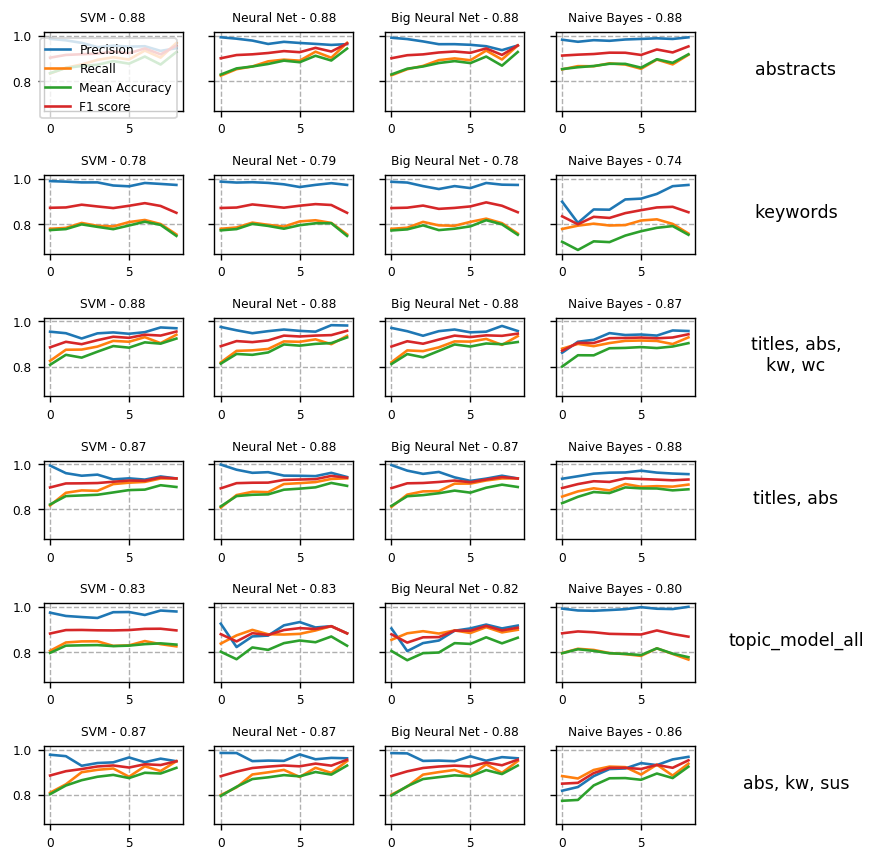

In [36]:
plt.rcParams['grid.linestyle'] = "--"
fig, axs = plt.subplots(
    len(xs),
    len(xs[0]['models'])+1,
    dpi=125,
    figsize=(double_figure[0],7),
    sharey=True
)
for i, x in enumerate(xs):
    for j, model in enumerate(x['models']):
        ax = axs[i,j]
        ax.plot(model['p'],label="Precision")
        ax.plot(model['r'],label="Recall")
        ax.plot(model['e'],label="Mean Accuracy")
        ax.plot(model['f'],label="F1 score")

        ax.set_title("{} - {:.2f}".format(model['title'],np.mean(model['e'])))
        ax.grid()
    ax = axs[i,len(xs[0]['models'])]
    ax.text(0.5,0.85,x['title'],ha="center",va="center")
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
    ax.axis('off')
axs[0,0].legend()
fig.tight_layout()
#plt.savefig("plots/model_comparison.png")


## By adjusting our probability threshold we can prioritise precision or recall

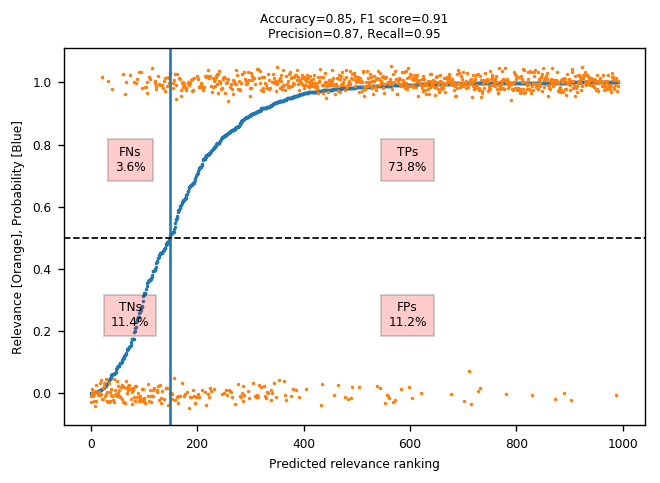

In [37]:
importlib.reload(utils)

local_x = ab_X

train = df.sample(frac=0.5).copy()
test = df[~df['id'].isin(train['id'])].copy()

clf = MLPClassifier(
            solver='lbfgs', 
            alpha=0.5,
            hidden_layer_sizes=(1200), 
            random_state=1
        )
#clf = MultinomialNB(alpha=0.1) 

clf.fit(local_x[train.index],y[train.index])

fig, ax = plt.subplots(dpi=125)

#print("Accuracy: {:.2f}".format(clf.score(local_x[test.index],y[test.index])))

utils.plot_model_accuracy(clf,local_x[test.index],y[test.index],ax, 0.5)

plt.savefig('../plots/example.png')

In [21]:
local_x.shape

(1984, 2088)

Average precision-recall score: 0.96


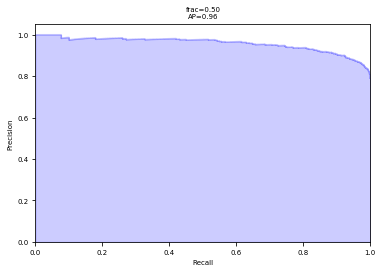

In [22]:
importlib.reload(utils)

fig, ax = plt.subplots()
utils.precision_recall_plot(clf,local_x[test.index],y[test.index],ax,0.5)

Confusion matrix, without normalization
[[120 103]
 [ 36 733]]


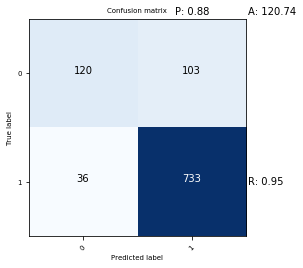

In [23]:
from sklearn.metrics import confusion_matrix
fig = plt.figure()
cnf = confusion_matrix(y[test.index],clf.predict(ab_X[test.index]))
utils.plot_confusion_matrix(cnf,classes=[0,1])

Confusion matrix, without normalization
[[  0 223]
 [  0 769]]
Confusion matrix, without normalization
[[ 72 151]
 [  6 763]]
Confusion matrix, without normalization
[[ 81 142]
 [ 12 757]]
Confusion matrix, without normalization
[[ 97 126]
 [ 16 753]]
Confusion matrix, without normalization
[[111 112]
 [ 25 744]]
Confusion matrix, without normalization
[[120 103]
 [ 36 733]]
Confusion matrix, without normalization
[[126  97]
 [ 43 726]]
Confusion matrix, without normalization
[[142  81]
 [ 59 710]]
Confusion matrix, without normalization
[[155  68]
 [ 82 687]]


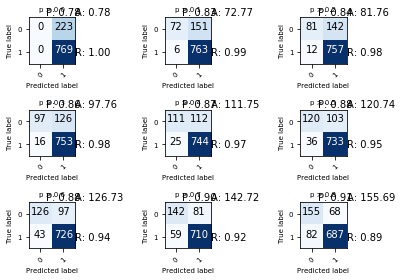

In [24]:
y_prob = clf.predict_proba(local_x[test.index])[:,1]
t = 0.1
y_pred = np.where(y_prob>t,1,0)
fig = plt.figure()
for i in range(9):
    t = i*0.1
    y_pred = np.where(y_prob>t,1,0)
    ax = fig.add_subplot(3,3,i+1)
    cnf = confusion_matrix(y[test.index],y_pred)
    utils.plot_confusion_matrix(cnf,classes=[0,1])
    ax.set_title("p > {:.1f}".format(t))

#plt.colorbar()
    
fig.tight_layout()

## False positives and false negatives

In [25]:
test['predicted'] = clf.predict(ab_X[test.index])
test['prob'] = clf.predict_proba(ab_X[test.index])[:,1]
fps = test[test['predicted']-test['relevant']==1].sort_values('prob',ascending=False)

fps.head()

,Unnamed: 0,UT_id,authors,content,first_author,id,rated,relevant,tag,title,wosarticle__de,wosarticle__wc,date,predicted,prob
1922,1760,WOS:000276726800004,"Choisis, JP, Sourdril, A, Deconchat, M, Balent...","The Coteaux de Gascogne region, an upland area...","Choisis, JP",78343,2018-09-07 07:49:17.424346+00:00,0,737,Understanding regional dynamics of mixed crop-...,France; geographical information systems; mixe...,"['Agriculture, Multidisciplinary; Agronomy']",2018-09-07 07:49:17,1,0.999839
1310,788,WOS:000257628400009,"Macher, C, Guyader, O, Talidec, C, Bertignac, M",The Nephrops trawl fishery is one of the most ...,"Macher, C",686419,2018-09-24 04:24:08.321493+00:00,0,753,A cost-benefit analysis of improving trawl sel...,Nephrops norvegicus; bio-economic simulations;...,['Fisheries'],2018-09-24 04:24:08,1,0.999725
883,2237,WOS:000293715400003,"Lockwood, M, Lockwood, M",Public support for climate policies is essenti...,"Lockwood, M",24982,2018-09-21 11:50:44.425019+00:00,0,760,Does the framing of climate policies make a di...,climate change policies; policy communication;...,['Environmental Studies; Public Administration'],2018-09-21 11:50:44,1,0.999350
1458,3106,WOS:000318263600003,"Germann, F, Lilien, GL, Rangaswamy, A",A few well-documented cases describe how the d...,"Germann, F",631039,2018-09-21 08:01:49.597473+00:00,0,760,Performance implications of deploying marketin...,Marketing analytics; Marketing models; Marketi...,['Business'],2018-09-21 08:01:49,1,0.998770
607,2663,WOS:000228115700008,"Vicziany, M",While this article broadly agrees with Peter G...,"Vicziany, M",246054,2018-09-20 13:16:33.779440+00:00,0,753,"Peter Gowan's ""American Grand Strategy"" An Asi...",,['Area Studies'],2018-09-20 13:16:33,1,0.998644


In [26]:
print('#########\nFALSE POSITIVES')

for i, row in fps.head(5).iterrows():
    print('\n####')
    print(row['title'])
    print("predicted: {:.2}, rated: {}".format(row['prob'],row['relevant']))
    print(row['content'])

#########
FALSE POSITIVES

####
Understanding regional dynamics of mixed crop-livestock agricultural systems to support rural development in South-western France uplands
predicted: 1.0, rated: 0
The Coteaux de Gascogne region, an upland area in south-western France, is a site where studies related to the future of landscapes and the sustainability of natural resource management are well documented. The local agricultural system is induced by a "house centred" society with the particularity of passing on the inheritance and farm estate identically from one generation to the next. This system generates a mosaic landscape made up of field crops, grasslands and woodlots. Local agriculture has experienced deep changes since the 1950s in relation with modernization and farm enlargement processes. Traditional farming systems were very diversified and turned towards subsistence. Nowadays, farming systems are market-oriented mixed crop-livestock farming, in which cattle is the main species rais

In [27]:
fns = test[test['predicted']-test['relevant']==-1].sort_values('prob')

fns.head()

,Unnamed: 0,UT_id,authors,content,first_author,id,rated,relevant,tag,title,wosarticle__de,wosarticle__wc,date,predicted,prob
793,1286,WOS:000340466400013,"Tacon, CE, Abbas, H, Zhang, SY, Nicholls, B, C...",Clinical research bridges patients' unmet medi...,"Tacon, CE",597641,2018-09-21 11:28:04.709797+00:00,1,760,Trends in Canadian respiratory clinical trials...,Canada; Clinical trials; Respiratory,['Respiratory System'],2018-09-21 11:28:04,0,0.001807
1289,564,WOS:000374156600002,"Agarwal, R, Green, R, Agarwal, N, Randhawa, K",Purpose - The purpose of this paper is to inve...,"Agarwal, R",413540,2018-09-21 04:49:45.436555+00:00,1,753,Benchmarking management practices in Australia...,Performance management; Management; Human reso...,['Health Policy & Services'],2018-09-21 04:49:45,0,0.023029
1951,740,WOS:000363069800008,"Villegas, L, Moran, R, Garcia, JJ",Guadua angustifolia (GA) is an American specie...,"Villegas, L",410826,2018-09-24 03:58:44.906857+00:00,1,760,A new joint to assemble light structures of ba...,Guadua angustifolia; Ductile behavior; Structu...,['Construction & Building Technology; Engineer...,2018-09-24 03:58:44,0,0.051761
1885,2841,WOS:000359048200001,"Weinhardt, LS, Galvao, LW, Mwenyekonde, T, Gra...","Background: Poverty and lack of a predictable,...","Weinhardt, LS",173287,2018-09-19 15:53:32.739740+00:00,1,753,Methods and protocol of a mixed method quasi-e...,Food security; Microfinance; Village savings a...,['Multidisciplinary Sciences'],2018-09-19 15:53:32,0,0.066869
1029,2268,WOS:000334898800075,"Lan, R, Alkhazmi, KA, Amar, IA, Tao, SW",Single phase perovskite oxide La0.8Cs0.2Fe0.8N...,"Lan, R",396020,2018-09-21 11:26:19.910414+00:00,1,760,Synthesis of ammonia directly from wet air usi...,Electrochemical synthesis; Ammonia; Air; Water...,['Electrochemistry'],2018-09-21 11:26:19,0,0.067743


In [28]:
print('#########\nFALSE NEGATIVES')

for i, row in fns.head(5).iterrows():
    print('\n####')
    print(row['title'])
    print("predicted: {:.2}, rated: {}".format(row['prob'],row['relevant']))
    print(row['content'])

#########
FALSE NEGATIVES

####
Trends in Canadian respiratory clinical trials from 2001 to 2011
predicted: 0.0018, rated: 1
Clinical research bridges patients' unmet medical need with innovative medicines, increases knowledge acquisition by clinicians, and creates solutions to improve the sustainability and quality of the Canadian health care system and economy. The Canadian Institutes of Health Research and the Canadian Lung Association have recently raised concerns over declining research activities within the Canadian respiratory community. While there are currently > 3000 ongoing clinical trials in Canada, the number of trials investigating common respiratory diseases is unknown. The objective of the present study was to monitor the trends in industry-and non-industry-sponsored respiratory clinical trials in Canada from 2001 to 2011. Trialtrove 2012 (Citeline, an Informa UK business), a database containing summarized clinical trial information regarding pharmaceutical products, wa

## Todos:
- Sustainable x features
- Ensemble methods, autosklearn
- Error overlap
- category exclusion

In [29]:



sus_tokenize( "The concept of long-term sustainable development")

# keywords



NameError: name 'sus_tokenize' is not defined

In [ ]:
importlib.reload(utils)

local_x = sus_X
local_x = hstack([ab_X,sus_X],format="csr")


train = df.sample(frac=0.5).copy()
test = df[~df['id'].isin(train['id'])].copy()

train_index = utils.undersample(train.index,y,0.6)

clf = MLPClassifier(
            solver='lbfgs', 
            alpha=0.2,
            hidden_layer_sizes=(100,20,5), 
            random_state=1
        )
#clf = MultinomialNB(alpha=0.1) 

clf.fit(local_x[train_index],y[train_index])


print("Accuracy: {:.2f}".format(clf.score(local_x[test.index],y[test.index])))



In [ ]:
fig, ax = plt.subplots(dpi=125)

utils.plot_model_accuracy(clf,local_x[test.index],y[test.index],ax, 0.95)

In [ ]:
model = clf
y_test = y[test.index]
x_test = local_x[test.index]
y_prob = model.predict_proba(x_test)
prob_y_true = y_prob[:,1]
prob_y_false = y_prob[:,0]

order = np.argsort(prob_y_true)
ordered_prob = prob_y_true[order]

order

np.array(y_test)[order]

In [ ]:
fig, ax = plt.subplots(dpi=125)
utils.precision_recall_plot(clf,local_x[test.index],y[test.index],ax,0.5)

In [ ]:
cnf = confusion_matrix(y[test.index],clf.predict(local_x[test.index]))
utils.plot_confusion_matrix(cnf,classes=[0,1])